# Advanced Model Building
In this example we'll examine the different ways one can go about building models in LUMIN, as well as how some of the more advanced block modules can be used.

We'll use the data from the Binary_Classification example, so you'll need to run through that first.

### Basic Modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from pathlib import Path
PATH = Path('data/')

## Data import
These objects get created during the Binary_Classification example.

In [3]:
from lumin.nn.data.fold_yielder import HEPAugFoldYielder
train_fy = HEPAugFoldYielder(PATH/'train.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [4]:
train_feats = train_fy.cont_feats+train_fy.cat_feats

## Model Building API approaches

A full network in LUMIN is constructed from three sub-modules:
- A `head` which takes in input features and applies any requested initial processing to them, e.g. entity embedding for categorical features
- A `body` which contains the hidden layers and performs most of the computation
- And a `tail` which downscales the output of the `body` to the reqested number of outputs and applies the final activation function on the network output

Normal usage of LUMIN expects to train a non-fixed number of models, so instead of creating models and training them, we instead specify how models should be created and use the `ModelBuilder` class to construct models on demand.

`ModelBuilder` has `model_args`, `head`, `body`, and `tail` parameters. The `head`, `body`, and `tail` parameters are used to set the block classes which are used for each block. By default they are:
- `CatEmbHead` - which provides categorical entity embedding for categorical inputs, parsing of continuous inputs, and separate Dropout rates for embedded and continuous inputs.
- `FullyConnected` - which provides a series of dense layers of variable width, dropout, batch normalisation, activation functions, as well as options for additative (ResNet-like) and concatination (DenseNet-like) skip connections.
- `ClassRegMulti` - which provides a single dense output layer with a suitable activation function.

Control of the various parameters of these blocks can be done in two ways:
1. `model_args` can be set to a dictionary of dictionaries of the form `{'head':{head_args},'body':{body_args},'tail':{tail_args}}`. These arguments are then passed to the relevant blocks when the network is built
1. the individual block parameters of `ModelBuilder` can be set to partial functions which when called will return a class with the desired parameters, e.g. body=partial(FullyConnected, width=100, depth=4)

### model_args approach
Let's look at the simplest approach where we specify block parameters in `model_args`. Note that since we don't specify parameters for the head block, `ModelBuilder` will add an empty dictionary automatically.

In [5]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import OldModel
from lumin.nn.models.helpers import CatEmbedder

bs = 256
objective = 'classification'
model_args = {'body':{'act':'swish', 'width':100, 'depth':4},
              'tail': {'bias_init':np.mean(train_fy.get_column('targets'))}}
opt_args = {'opt':'adam', 'eps':1e-08}
cat_embedder = CatEmbedder.from_fy(train_fy)

n_out = 1
model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, opt_args=opt_args)

OldModel(model_builder)

Inputs:
30 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_pt']
                   
1  Categorical: ['PRI_jet_num']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=32, out_features=100, bias=True)
        (1): Swis

### Partial approach
Now let's look at a fully `partial`-based approach

In [6]:
from functools import partial
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.blocks.tail import ClassRegMulti

body = partial(FullyConnected, depth=4, width=100, act='swish')
tail = partial(ClassRegMulti, bias_init=np.mean(train_fy.get_column('targets')))

model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             body=body, tail=tail, opt_args=opt_args)

OldModel(model_builder)

Inputs:
30 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_pt']
                   
1  Categorical: ['PRI_jet_num']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=32, out_features=100, bias=True)
        (1): Swis

### model_args + partial hybrid approach
We can even use a mixture of `partial` and argument specification for different parts of the network

In [7]:
model_args = {'tail': {'bias_init':np.mean(train_fy.get_column('targets'))}}
body = partial(FullyConnected, depth=4, width=100, act='swish')

model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, body=body, opt_args=opt_args)

OldModel(model_builder)

Inputs:
30 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_pt']
                   
1  Categorical: ['PRI_jet_num']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=32, out_features=100, bias=True)
        (1): Swis

## Advanced Model Building

### MultiBlock Body
The default body block `FullyConnected` treats all outputs of the head block as the same and passes them all through dense layers together, however we may have features which we want to treat differently. E.g. in particle physics we have low-level features, which could be a raw representation of the collision (e.g. final-state 4-momenta), however we commonly compute several high-level features, which are theory inspired non-linear combinations of low-level features.

In the example data we have both high (`DER_`) and low (`PRI_`) features, which we may want to try treating differently; perhaps the low-level features might require a deeper network to learn a useful representation for them, whereas the high-level features might simply require a single layer. See e.g [Wide-Deep Models](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html)

Using the `MultiBlock` body we can define a sets of features and a corresponding series of `FullyConnected` objects. Because `ClassRegMulti` takes in named features and provides a maping of feature names to its outputs, we can specify subsets of named featured to `MultiBlock`'s `feats_per_block` parameter in order to pass the correct features though each sub-body block which are defined as partials in the `blocks` parameter.

In [8]:
OldModel(model_builder).head.feat_map

{'DER_mass_MMC': [0],
 'DER_mass_transverse_met_lep': [1],
 'DER_mass_vis': [2],
 'DER_pt_h': [3],
 'DER_deltaeta_jet_jet': [4],
 'DER_mass_jet_jet': [5],
 'DER_prodeta_jet_jet': [6],
 'DER_deltar_tau_lep': [7],
 'DER_pt_tot': [8],
 'DER_sum_pt': [9],
 'DER_pt_ratio_lep_tau': [10],
 'DER_met_phi_centrality': [11],
 'DER_lep_eta_centrality': [12],
 'PRI_met_sumet': [13],
 'PRI_jet_all_pt': [14],
 'PRI_jet_leading_px': [15],
 'PRI_jet_leading_py': [16],
 'PRI_jet_leading_pz': [17],
 'PRI_met_px': [18],
 'PRI_met_py': [19],
 'PRI_lep_px': [20],
 'PRI_lep_py': [21],
 'PRI_lep_pz': [22],
 'PRI_jet_subleading_px': [23],
 'PRI_jet_subleading_py': [24],
 'PRI_jet_subleading_pz': [25],
 'PRI_tau_px': [26],
 'PRI_tau_py': [27],
 'PRI_tau_pz': [28],
 'PRI_met_pt': [29],
 'PRI_jet_num': [30, 31]}

To start, we'll send the high-level features through a single wide layer, and both the high and low level features through a deep network. Diagrammatically, the network will look like:
<img src="imgs/semisplit.png" width="512">

In [9]:
from lumin.nn.models.blocks.body import MultiBlock

hl_feats = [f for f in train_feats if 'DER_' in f]
ll_feats = [f for f in train_feats if 'PRI_' in f]

model_args = {'tail': {'bias_init':np.mean(train_fy.get_column('targets'))}}

body = partial(MultiBlock,
               blocks=[partial(FullyConnected, depth=1, width=50, act='swish'),
                       partial(FullyConnected, depth=6, width=33, act='swish', dense=True)],
               feats_per_block=[hl_feats,train_feats])

model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, body=body, opt_args=opt_args)
OldModel(model_builder)

Inputs:
30 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_pt']
                   
1  Categorical: ['PRI_jet_num']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): MultiBlock(
    (blocks): ModuleList(
      (0): FullyConnected(
        (layers): Sequential(
          (0): Sequential(
            (0): Linear(i

Maybe it would be possible to get away only sending the low-level features though the deep network, however it is likely that some interaction between low- and high-level features will be beneficial. We can use the `bottleneck_sz` and `bottleneck_act` parameters to create extra bottleneck layers. There will be one per sub-body block which will take in all the features which its corresponding block does not use, pass them through a narrow dense layer (and optionally an activation function) and concatinate its output to the other input features before they are passed though the block. Effectively, the block now sees both its specified input features and a highly compressed representation of all features it would otherwise not use. Hopefully this should allow the features to be split, whilst still allowing some interaction between the features witout the number of free-parameters in the model becoming too great.

<img src="imgs/fullsplit+bn.png" width="512">

In [10]:
body = partial(MultiBlock,
               blocks=[partial(FullyConnected, depth=1, width=50, act='swish'),
                       partial(FullyConnected, depth=6, width=20, act='swish', dense=True)],
               feats_per_block=[hl_feats,ll_feats],
               bottleneck_sz=1, bottleneck_act='swish')

model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, body=body, opt_args=opt_args)
OldModel(model_builder)

Inputs:
30 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_pt']
                   
1  Categorical: ['PRI_jet_num']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): MultiBlock(
    (bottleneck_blocks): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=19, out_features=1, bias=True)
        (1):

## Interpretation

### Full-split architecture
Splitting the computation of features can allow us to also better interpret the model once its trained. In this example we have a single output neuron, which will take as inputs the row-wise concatination of the tensors computed by the `MultiBlock` body. For an example input we can compute then the dot product of the output neuron's weights corresponding to each sub-body block with the outputs of each sub-body block. By repeating this for many example inputs we can see the overall reliance of the output layer on the different blocks, and in so doing the overall reliance of the model on the different sets of input features.

To test this, lets remove the bottleneck layers so the outputs of each sub-body block only depend on the either the low- or high-level features.

<img src="imgs/fullsplit.png" width="512">

In [11]:
body = partial(MultiBlock,
               blocks=[partial(FullyConnected, depth=1, width=50, act='swish'),
                       partial(FullyConnected, depth=6, width=19, act='swish', dense=True)],
               feats_per_block=[hl_feats,ll_feats])

model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, body=body, opt_args=opt_args)
OldModel(model_builder)

Inputs:
30 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_pt']
                   
1  Categorical: ['PRI_jet_num']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): MultiBlock(
    (blocks): ModuleList(
      (0): FullyConnected(
        (layers): Sequential(
          (0): Sequential(
            (0): Linear(i

We now want to train a single model

LR finder took 3.909s 


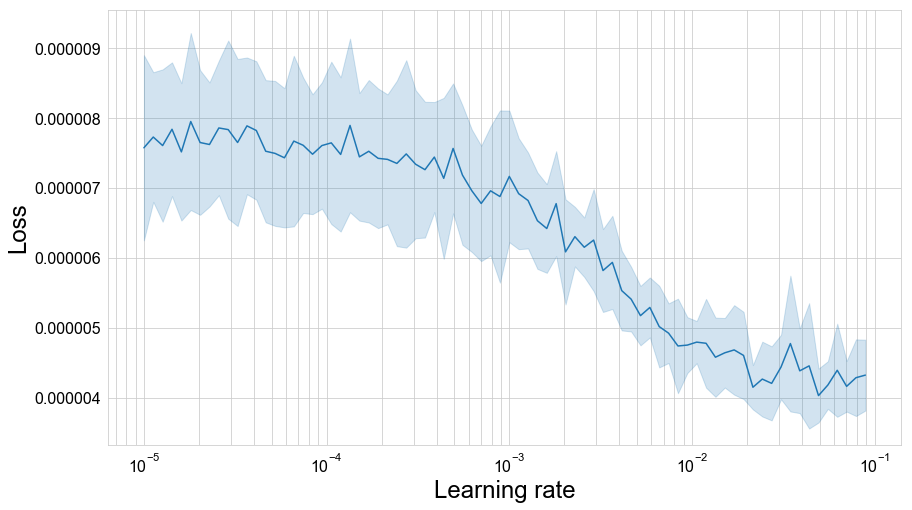

In [12]:
from lumin.optimisation.hyper_param import fold_lr_find
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e-1])

In [13]:
from lumin.nn.callbacks.cyclic_callbacks import OldOneCycle
from lumin.nn.metrics.class_eval import AMS

callback_partials = [partial(OldOneCycle, lengths=(45, 90), lr_range=[1e-4, 1e-2])]
eval_metrics = {'AMS':AMS(n_total=250000, br=10, wgt_name='gen_orig_weight')}

Training model 1 / 1, Val ID = 0


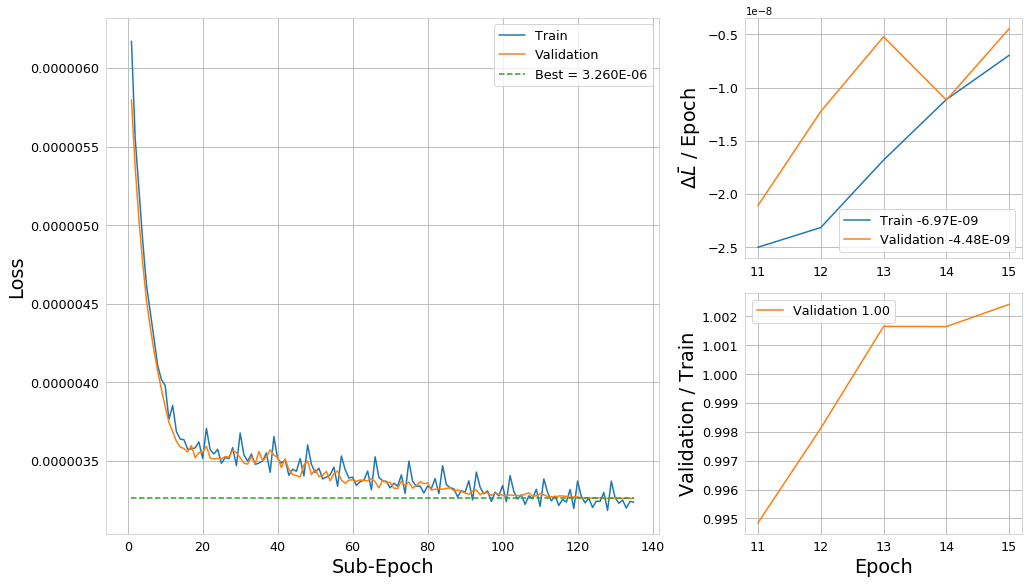

Early stopping after 135 sub-epochs
Scores are: {'loss': 3.260482799305464e-06, 'AMS': 3.5595775944020467}
Fold took 61.832s


______________________________________
Training finished
Cross-validation took 62.286s 


<Figure size 1024x576 with 0 Axes>

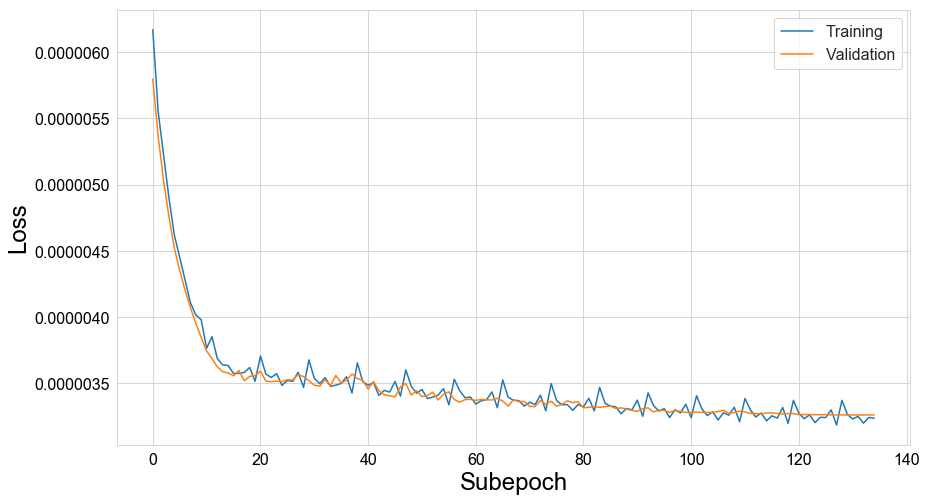

Mean loss = 3.260482799305464e-06±0.0
Mean AMS = 3.5595775944020467±0.0
______________________________________



In [14]:
from lumin.nn.training.fold_train import fold_train_ensemble

results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models=1,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       callback_partials=callback_partials,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=15)

In [15]:
model = OldModel.from_save('train_weights/train_0.h5', model_builder)

Having loaded our trained model, lets pass a fold of training data though it, record the inputs to the tail block, and then compute the absolute values of the dot products of the weights with the inputs coming from each sub-body block. We can show the general trend for the data as a box-and-whisker diagram

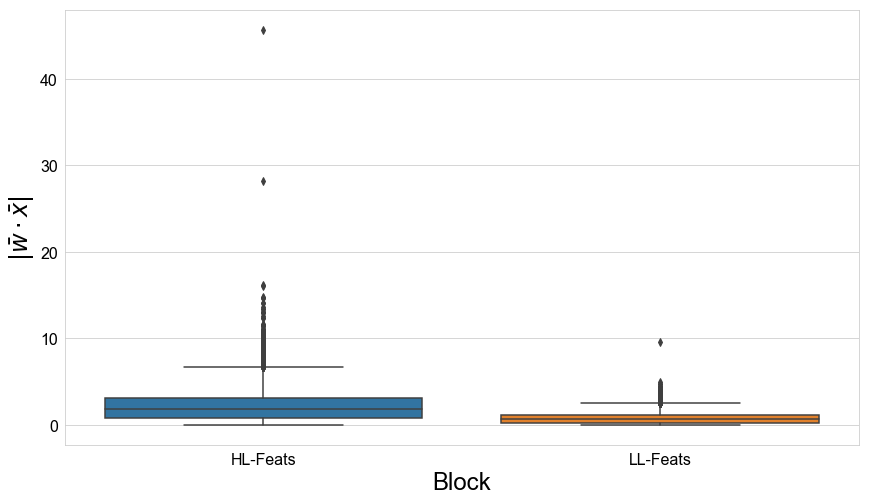

In [16]:
from lumin.plotting.interpretation import plot_multibody_weighted_outputs

plot_multibody_weighted_outputs(model=model, inputs=train_fy[1]['inputs'], block_names=['HL-Feats', 'LL-Feats'])

So overall it seems then the high-level features have the greatest influence on the final output of our model, which seems to be in agreement with what we find when computing the individual permutation importance of the features

Top ten most important features:
                        Feature  Importance  Uncertainty
0                 DER_mass_vis    0.704418     0.035033
1           DER_deltar_tau_lep    0.564255     0.017393
2  DER_mass_transverse_met_lep    0.278547     0.010996
3                 DER_mass_MMC    0.257500     0.012661
4         DER_pt_ratio_lep_tau    0.190779     0.011284
5                   DER_sum_pt    0.171167     0.004897
6                   PRI_tau_py    0.108128     0.009315
7                   PRI_tau_px    0.106016     0.008972
8                   PRI_lep_py    0.102318     0.006474
9                   PRI_lep_px    0.089648     0.007750


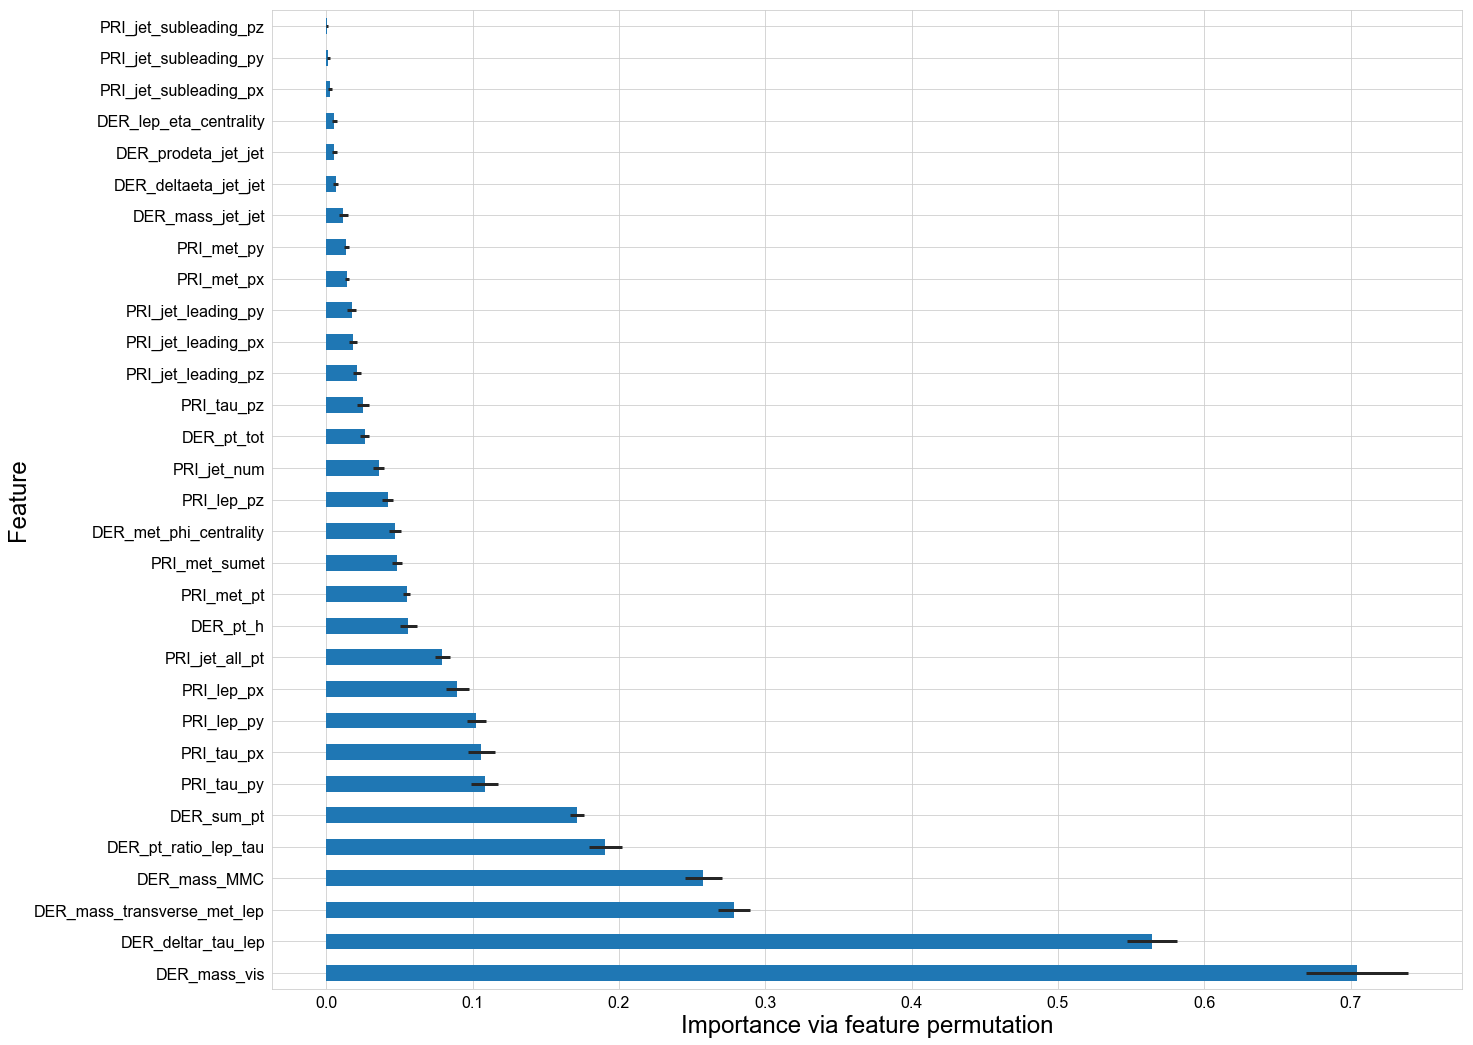

In [17]:
_ = model.get_feat_importance(train_fy)

### Full-split + bottlenecks architecture
Adding the bottleneck layers will likely improve performance, since each block now has access to more information - the bottlenecks can learn the most useful representation of the data which would otherwise not be available, whist still reducing the number of free parameters in the model compared to feeding all the inputs into the same block.

We can interpret the bottleneck layers in several ways:
 - one is to plot the dependence on each input feature by plotting the absolute values of the layer weights times the feature values for some example data
 - another way is to plot the distributions of the outputs of the bottlenecks for some example data

To test this, lets add the bottleneck layers back in so and train a model

In [18]:
body = partial(MultiBlock,
               blocks=[partial(FullyConnected, depth=1, width=51, act='swish'),
                       partial(FullyConnected, depth=6, width=20, act='swish', dense=True)],
               feats_per_block=[hl_feats,ll_feats], bottleneck_sz=1, bottleneck_act='swish')

model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, body=body, opt_args=opt_args)
OldModel(model_builder)

Inputs:
30 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_pt']
                   
1  Categorical: ['PRI_jet_num']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): MultiBlock(
    (bottleneck_blocks): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=19, out_features=1, bias=True)
        (1):

We now want to train a single model

LR finder took 4.745s 


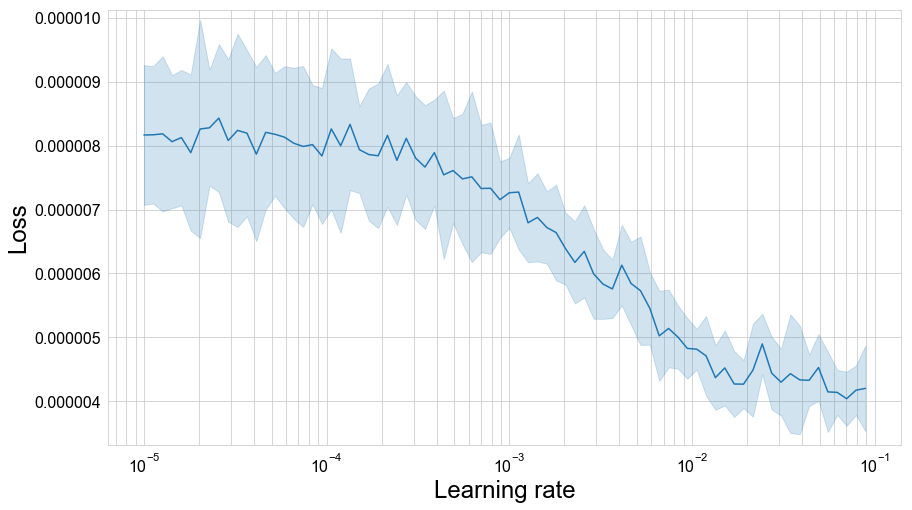

In [19]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e-1])

In [21]:
callback_partials = [partial(OldOneCycle, lengths=(45, 90), lr_range=[1e-4, 1e-2])]

Training model 1 / 1, Val ID = 0


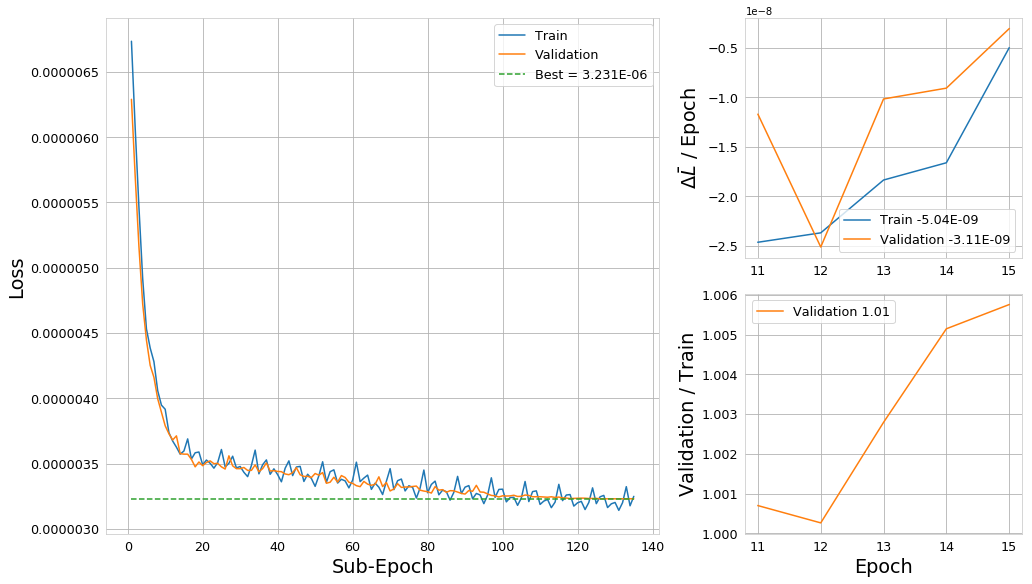

Early stopping after 135 sub-epochs
Scores are: {'loss': 3.2310917958966456e-06, 'AMS': 3.5510920054815283}
Fold took 73.949s


______________________________________
Training finished
Cross-validation took 74.386s 


<Figure size 1024x576 with 0 Axes>

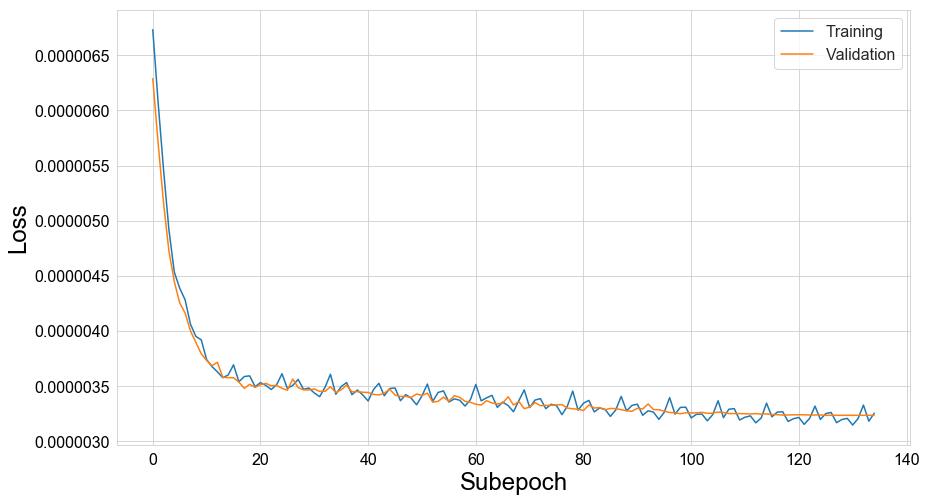

Mean loss = 3.2310917958966456e-06±0.0
Mean AMS = 3.5510920054815283±0.0
______________________________________



In [22]:
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models=1,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       callback_partials=callback_partials,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=15)

In [23]:
model = OldModel.from_save('train_weights/train_0.h5', model_builder)

Having loaded our trained model, lets pass a fold of training data though it, record the inputs to the bottlenecks and compute the absolute values of the weights times the input features. We can show the general trend for the data as a box-and-whisker diagram

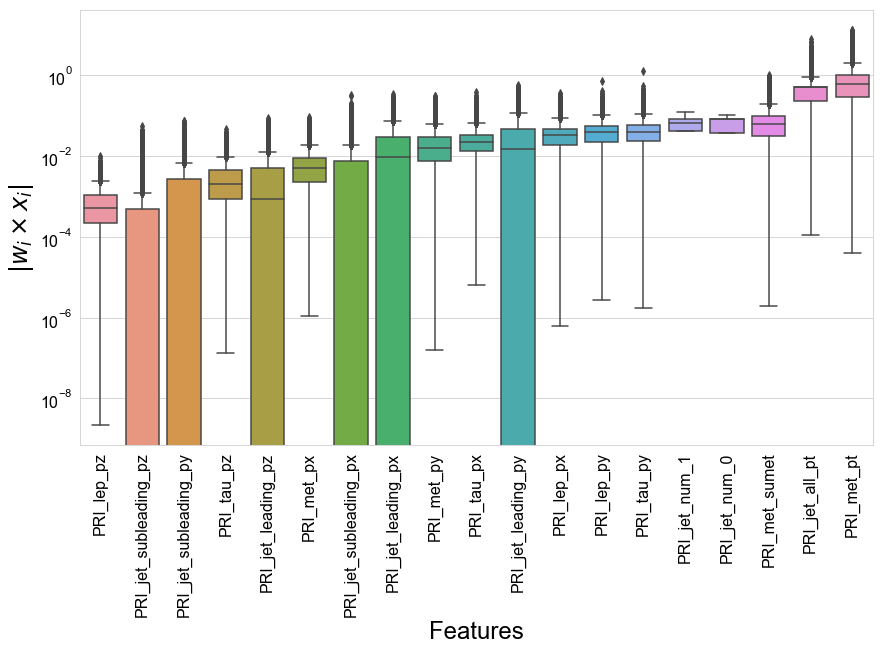

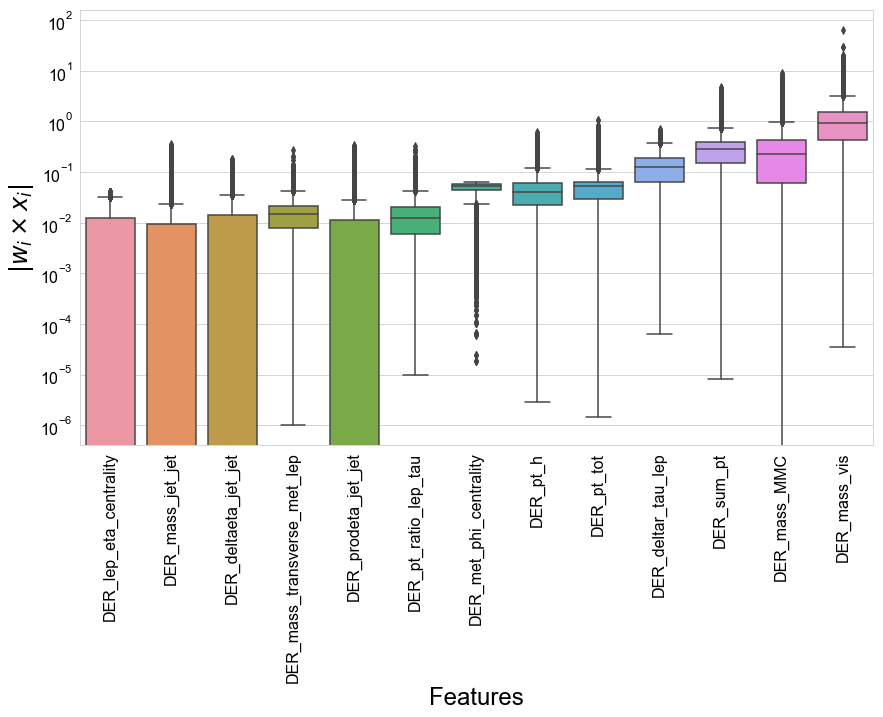

In [24]:
from lumin.plotting.interpretation import plot_bottleneck_weighted_inputs

plot_bottleneck_weighted_inputs(model, bottleneck_idx=0, inputs=train_fy[1]['inputs'])
plot_bottleneck_weighted_inputs(model, bottleneck_idx=1, inputs=train_fy[1]['inputs'])

From the top plot we can see that the low-level bottleneck (top plot) focusses on encoding MET and the jet multiplicity embeddings, which could then be used by the high-level shallow-layer to parameterise the response to the di-jet features (which are quite weak on their own without knowledge of jet multiplicity).

The high-level bottleneck (bottom plot) only really focuses on the stronger HL features, possibly suggesting that the deep block is being used to further refine them.

We can also plot the output distributions for each bottleneck

In [26]:
from typing import Union
from torch import Tensor
from lumin.utils.misc import FowardHook, to_np

def get_bottleneck_output(model:OldModel, bottleneck_idx:int, inputs:Union[np.ndarray,Tensor]) -> np.ndarray:
    bn = model.body.bottleneck_blocks[bottleneck_idx]
    hook = FowardHook(bn[-1])
    model.predict(inputs)
    return to_np(hook.output.squeeze())

In [27]:
df = pd.DataFrame()
data = train_fy[1]
df = pd.DataFrame()
df['gen_target'] = data['targets'].squeeze()
df['gen_weight'] = data['weights'].squeeze()
df['LL_bottleneck'] = get_bottleneck_output(model, 0, data['inputs'])
df['HL_bottleneck'] = get_bottleneck_output(model, 1, data['inputs'])

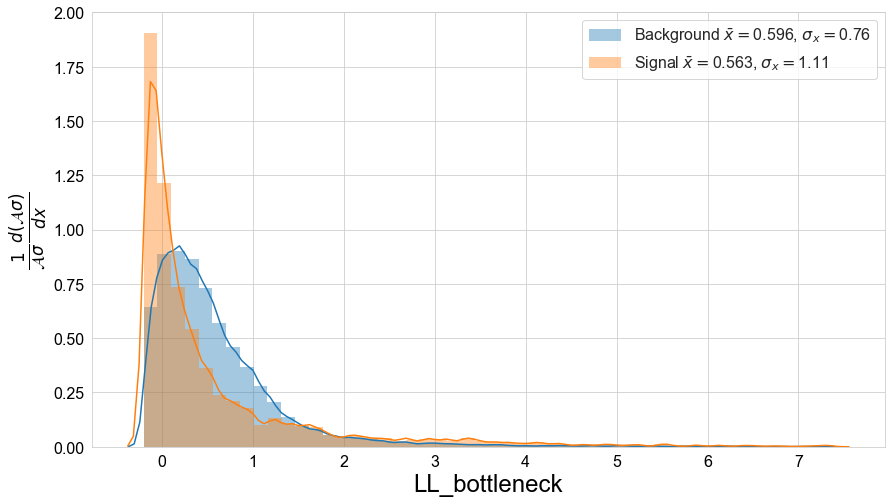

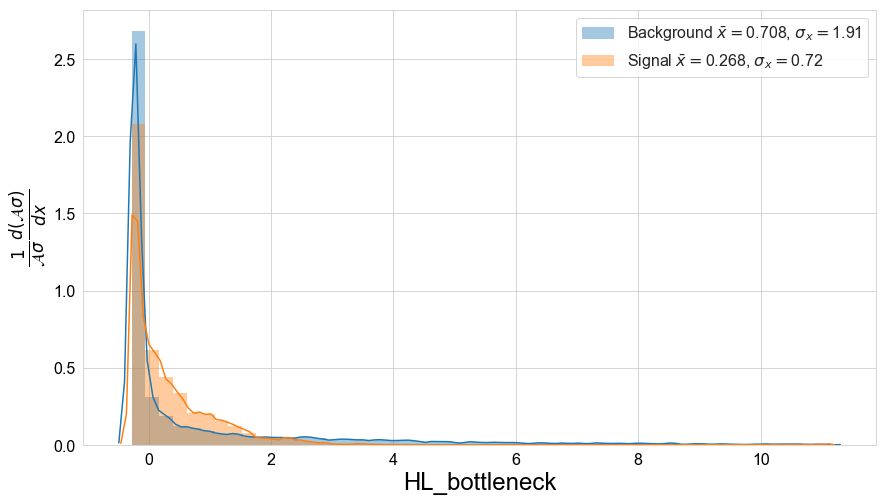

In [28]:
from lumin.plotting.data_viewing import plot_feat

plot_feat(df, 'LL_bottleneck', cuts=[(df.gen_target==0), (df.gen_target==1)],
          labels=['Background', 'Signal'], wgt_name='gen_weight',
          ax_labels={'y':r"$\frac{1}{\mathcal{A}\sigma} \frac{d(\mathcal{A}\sigma)}{dx}$",
                     'x':r"LL_bottleneck"})
plot_feat(df, 'HL_bottleneck', cuts=[(df.gen_target==0), (df.gen_target==1)],
          labels=['Background', 'Signal'], wgt_name='gen_weight',
          ax_labels={'y':r"$\frac{1}{\mathcal{A}\sigma} \frac{d(\mathcal{A}\sigma)}{dx}$",
                     'x':r"HL_bottleneck"})

The low-level bottleneck not only learns a discriminating feature, but also displays a double-peak structure. Since we've seen that the bottleneck focuses on jet-multiplicity, it's likely that one of these peaks corresponds to events with no jets.

The high-level bottleneck appears to be encoding features with mild discrimination, so perhaps the deep block is using the low-level information to further refine the weaker high-level features.